In [1]:
# --- Environment setup (local venv/conda) ---
# Optionnel : exécuter uniquement si des packages manquent.
# Installe la version d’Evidently attendue par ce notebook.
import sys, subprocess

requirements = [
    "evidently==0.7.20",
    "mlflow",
    "shap",
    "lightgbm",
    "xgboost",
    "scikit-learn",
    "pandas",
    "numpy",
    "matplotlib",
    "pyarrow",
]

subprocess.check_call([sys.executable, "-m", "pip", "install"] + requirements)

# Quick version check
from importlib.metadata import version
for pkg in ["evidently", "mlflow", "shap", "lightgbm", "xgboost", "sklearn", "pandas", "numpy"]:
    try:
        print(f"{pkg}: {version(pkg)}")
    except Exception as e:
        print(f"{pkg}: not found ({e})")


  Using cached pandas-3.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (79 kB)
  Using cached numpy-2.4.1-cp313-cp313-macosx_14_0_arm64.whl.metadata (6.6 kB)
  Using cached pyarrow-23.0.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (3.0 kB)
INFO: pip is looking at multiple versions of pandas[parquet] to determine which version is compatible with other requirements. This could take a while.
evidently: 0.7.20
mlflow: 3.9.0
shap: 0.50.0
lightgbm: 4.6.0
xgboost: 3.1.3
sklearn: not found (No package metadata was found for sklearn)
pandas: 2.3.3
numpy: 2.3.5


# Projet 7 — Modèle de scoring (Home Credit)

Exécuter les cellules dans l’ordre. Le notebook gère : préprocessing, entraînement + CV, tracking MLflow + Registry, interprétabilité (SHAP) et data drift (Evidently).


In [2]:
# 📌 Initialisation LOCAL – chemins, dossiers, MLflow local (exécuter en 1er)

import os
from pathlib import Path
import mlflow

# 0) Racine projet (idéalement racine du repo)
ROOT = Path.cwd().expanduser().resolve()

# 1) Chemins configurables via variables d'environnement
DATA_DIR = Path(os.getenv("DATA_DIR", ROOT / "data")).expanduser().resolve()
OUTPUT_DIR = Path(os.getenv("OUTPUT_DIR", ROOT / "outputs")).expanduser().resolve()

# 2) Dossiers standards
CLEAN_DIR = OUTPUT_DIR / "cleaned"
FIGURES_DIR = OUTPUT_DIR / "figures"
MODELS_DIR = OUTPUT_DIR / "models"
REPORTS_DIR = OUTPUT_DIR / "reports"

for d in [OUTPUT_DIR, CLEAN_DIR, FIGURES_DIR, MODELS_DIR, REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

DF_TEST_PATH = CLEAN_DIR / "dataframe_test.csv"

print("✅ ROOT:", ROOT)
print("✅ DATA_DIR:", DATA_DIR)
print("✅ OUTPUT_DIR:", OUTPUT_DIR)
print("✅ CLEAN_DIR:", CLEAN_DIR)
print("✅ FIGURES_DIR:", FIGURES_DIR)
print("✅ MODELS_DIR:", MODELS_DIR)
print("✅ REPORTS_DIR:", REPORTS_DIR)
print("✅ DF_TEST_PATH:", DF_TEST_PATH)

# 3) MLflow - tracking local (FileStore) dans ./mlruns
MLRUNS_DIR = Path(os.getenv("MLRUNS_DIR", ROOT / "mlruns")).expanduser().resolve()
MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(f"file://{MLRUNS_DIR.as_posix()}")
mlflow.set_registry_uri(f"file://{MLRUNS_DIR.as_posix()}")

EXPERIMENT_NAME = os.getenv("MLFLOW_EXPERIMENT_NAME", "home_credit_scoring")
mlflow.set_experiment(EXPERIMENT_NAME)

exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print("✅ MLflow tracking uri:", mlflow.get_tracking_uri())
print("✅ MLflow experiment:", EXPERIMENT_NAME)
print("✅ MLflow experiment_id:", exp.experiment_id if exp else None)

# 4) Compatibilité "ancienne variable" utilisée dans ton code
#    IMPORTANT: chemin = DATA_DIR (inputs). Pour les outputs, utilise OUTPUT_DIR / ...
chemin = DATA_DIR

# 5) Garde-fou: données présentes ?
if not DATA_DIR.exists():
    raise FileNotFoundError(
        f"DATA_DIR introuvable: {DATA_DIR}\n"
        "➡️ Mets les CSV dans ./data OU exporte DATA_DIR=/chemin/vers/dossier_data"
    )

# 6) Vérif rapide des fichiers requis (fail fast)
required = [
    "application_train.csv",
    "application_test.csv",
    "bureau.csv",
    "bureau_balance.csv",
    "previous_application.csv",
    "POS_CASH_balance.csv",
    "installments_payments.csv",
    "credit_card_balance.csv",
]
missing = [f for f in required if not (DATA_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        "Fichiers manquants dans DATA_DIR:\n- " + "\n- ".join(missing) +
        f"\n\nDATA_DIR actuel: {DATA_DIR}"
    )

print("✅ Tous les fichiers requis sont présents.")


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ ROOT: /Users/andersoncarbeti/Projet_7_final/Projet_7_final
✅ DATA_DIR: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/data
✅ OUTPUT_DIR: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs
✅ CLEAN_DIR: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/cleaned
✅ FIGURES_DIR: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/figures
✅ MODELS_DIR: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/models
✅ REPORTS_DIR: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/reports
✅ DF_TEST_PATH: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/cleaned/dataframe_test.csv
✅ MLflow tracking uri: file:///Users/andersoncarbeti/Projet_7_final/Projet_7_final/mlruns
✅ MLflow experiment: home_credit_scoring
✅ MLflow experiment_id: 334112140175451421
✅ Tous les fichiers requis sont présents.


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## MLflow UI (local)

Pour visualiser l'expérience, comparer les runs et consulter le Model Registry :

```bash
mlflow ui --backend-store-uri ./mlruns --port 5000
```

Puis ouvrir : `http://127.0.0.1:5000`

À montrer en soutenance :
- Experiments → `home_credit_scoring`
- Comparaison des runs (métriques + params)
- Model Registry → `home_credit_default_model` → alias `champion`


## MLflow (local)

Tracking et Model Registry en local via `./mlruns`.


In [3]:
import numpy as np
import pandas as pd
import gc
import time
import shutil
from contextlib import contextmanager

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             classification_report, make_scorer,
                             precision_recall_curve, PrecisionRecallDisplay)
from sklearn.model_selection import (learning_curve, GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
import mlflow
from mlflow.tracking import MlflowClient
import shap
import joblib
from mlflow.models.signature import infer_signature

from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
pd.set_option('display.max_row', 800)
pd.set_option("display.max_columns", None)
set_config(display="text")
sns.set_theme(style='whitegrid', palette='pastel')

In [5]:
def one_hot_encoder(df, nan_as_category=True):
    """One-hot encoding for categorical columns with get_dummies"""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category, dtype=int)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## Fonctions

In [6]:
def application_train_test(data_dir, num_rows=None, nan_as_category=False):
    """Preprocess application_train.csv and application_test.csv"""
    data_dir = Path(data_dir).expanduser().resolve()

    df = pd.read_csv(data_dir / "application_train.csv", nrows=num_rows)
    test_df = pd.read_csv(data_dir / "application_test.csv", nrows=num_rows)
    print(f"Train samples: {len(df)}, test samples: {len(test_df)}")

    df = pd.concat([df, test_df], ignore_index=True)
    df = df[df["CODE_GENDER"] != "XNA"]

    for col in ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
        df[col], _ = pd.factorize(df[col])

    df, _ = one_hot_encoder(df, nan_as_category=nan_as_category)

    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

    df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]

    del test_df
    gc.collect()
    return df


def bureau_and_balance(data_dir, num_rows=None, nan_as_category=True):
    """Preprocess bureau.csv and bureau_balance.csv"""
    data_dir = Path(data_dir).expanduser().resolve()

    bureau = pd.read_csv(data_dir / "bureau.csv", nrows=num_rows)
    bb = pd.read_csv(data_dir / "bureau_balance.csv", nrows=num_rows)

    bb, bb_cat = one_hot_encoder(bb, nan_as_category=nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=nan_as_category)

    # Bureau balance aggregations then merge into bureau
    bb_aggregations = {"MONTHS_BALANCE": ["min", "max", "size"]}
    for col in bb_cat:
        bb_aggregations[col] = ["mean"]

    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index([f"{c}_{stat.upper()}" for c, stat in bb_agg.columns.to_list()])

    bureau = bureau.join(bb_agg, how="left", on="SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis=1, inplace=True)

    del bb, bb_agg
    gc.collect()

    # Numeric aggregations
    num_aggregations = {
        "DAYS_CREDIT": ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE": ["mean"],
        "CREDIT_DAY_OVERDUE": ["max", "mean"],
        "AMT_CREDIT_MAX_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM_LIMIT": ["mean", "sum"],
        "AMT_ANNUITY": ["max", "mean"],
        "CNT_CREDIT_PROLONG": ["sum"],
        "MONTHS_BALANCE_MIN": ["min"],
        "MONTHS_BALANCE_MAX": ["max"],
        "MONTHS_BALANCE_SIZE": ["mean", "sum"],
    }

    # Categorical aggregations
    cat_aggregations = {cat: ["mean"] for cat in bureau_cat}
    for cat in bb_cat:
        cat_aggregations[f"{cat}_MEAN"] = ["mean"]

    bureau_agg = bureau.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index([f"BURO_{c}_{stat.upper()}" for c, stat in bureau_agg.columns.to_list()])

    # Active credits
    if "CREDIT_ACTIVE_Active" in bureau.columns:
        active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
        active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
        active_agg.columns = pd.Index([f"ACTIVE_{c}_{stat.upper()}" for c, stat in active_agg.columns.to_list()])
        bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")
        del active, active_agg
        gc.collect()

    # Closed credits
    if "CREDIT_ACTIVE_Closed" in bureau.columns:
        closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
        closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
        closed_agg.columns = pd.Index([f"CLOSED_{c}_{stat.upper()}" for c, stat in closed_agg.columns.to_list()])
        bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")
        del closed, closed_agg
        gc.collect()

    del bureau
    gc.collect()
    return bureau_agg
from pathlib import Path

def previous_applications(data_dir, num_rows=None, nan_as_category=True):
    """Preprocess previous_application.csv"""
    data_dir = Path(data_dir).expanduser().resolve()

    prev = pd.read_csv(data_dir / "previous_application.csv", nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=nan_as_category)

    # 365243 -> NaN
    for col in ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"]:
        if col in prev.columns:
            prev[col].replace(365243, np.nan, inplace=True)

    prev["APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]

    num_aggregations = {
        "AMT_ANNUITY": ["min", "max", "mean"],
        "AMT_APPLICATION": ["min", "max", "mean"],
        "AMT_CREDIT": ["min", "max", "mean"],
        "APP_CREDIT_PERC": ["min", "max", "mean", "var"],
        "AMT_DOWN_PAYMENT": ["min", "max", "mean"],
        "AMT_GOODS_PRICE": ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START": ["min", "max", "mean"],
        "RATE_DOWN_PAYMENT": ["min", "max", "mean"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "sum"],
    }

    cat_aggregations = {cat: ["mean"] for cat in cat_cols}

    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index([f"PREV_{c}_{stat.upper()}" for c, stat in prev_agg.columns.to_list()])

    # Approved
    if "NAME_CONTRACT_STATUS_Approved" in prev.columns:
        approved = prev[prev["NAME_CONTRACT_STATUS_Approved"] == 1]
        approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
        approved_agg.columns = pd.Index([f"APPROVED_{c}_{stat.upper()}" for c, stat in approved_agg.columns.to_list()])
        prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")
        del approved, approved_agg
        gc.collect()

    # Refused
    if "NAME_CONTRACT_STATUS_Refused" in prev.columns:
        refused = prev[prev["NAME_CONTRACT_STATUS_Refused"] == 1]
        refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
        refused_agg.columns = pd.Index([f"REFUSED_{c}_{stat.upper()}" for c, stat in refused_agg.columns.to_list()])
        prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")
        del refused, refused_agg
        gc.collect()

    del prev
    gc.collect()
    return prev_agg


def pos_cash(data_dir, num_rows=None, nan_as_category=True):
    """Preprocess POS_CASH_balance.csv"""
    data_dir = Path(data_dir).expanduser().resolve()

    pos = pd.read_csv(data_dir / "POS_CASH_balance.csv", nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=nan_as_category)

    aggregations = {
        "MONTHS_BALANCE": ["max", "mean", "size"],
        "SK_DPD": ["max", "mean"],
        "SK_DPD_DEF": ["max", "mean"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    pos_agg.columns = pd.Index([f"POS_{c}_{stat.upper()}" for c, stat in pos_agg.columns.to_list()])
    pos_agg["POS_COUNT"] = pos.groupby("SK_ID_CURR").size()

    del pos
    gc.collect()
    return pos_agg


def installments_payments(data_dir, num_rows=None, nan_as_category=True):
    """Preprocess installments_payments.csv"""
    data_dir = Path(data_dir).expanduser().resolve()

    ins = pd.read_csv(data_dir / "installments_payments.csv", nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=nan_as_category)

    ins["PAYMENT_PERC"] = ins["AMT_PAYMENT"] / ins["AMT_INSTALMENT"]
    ins["PAYMENT_DIFF"] = ins["AMT_INSTALMENT"] - ins["AMT_PAYMENT"]

    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)

    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "PAYMENT_PERC": ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF": ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index([f"INSTAL_{c}_{stat.upper()}" for c, stat in ins_agg.columns.to_list()])
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()

    del ins
    gc.collect()
    return ins_agg


def credit_card_balance(data_dir, num_rows=None, nan_as_category=True):
    """Preprocess credit_card_balance.csv"""
    data_dir = Path(data_dir).expanduser().resolve()

    cc = pd.read_csv(data_dir / "credit_card_balance.csv", nrows=num_rows)
    cc, _ = one_hot_encoder(cc, nan_as_category=nan_as_category)

    if "SK_ID_PREV" in cc.columns:
        cc.drop(["SK_ID_PREV"], axis=1, inplace=True)

    cc_agg = cc.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    cc_agg.columns = pd.Index([f"CC_{c}_{stat.upper()}" for c, stat in cc_agg.columns.to_list()])
    cc_agg["CC_COUNT"] = cc.groupby("SK_ID_CURR").size()

    del cc
    gc.collect()
    return cc_agg

In [7]:
def main(data_dir, num_rows=10000, debug=False):
    """
    Pipeline complet de préprocessing + feature engineering.
    - data_dir : dossier contenant les CSV Home Credit
    - num_rows : limite de lignes (None = tout charger)
    """
    data_dir = Path(data_dir).expanduser().resolve()

    df = application_train_test(data_dir, num_rows=num_rows)

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(data_dir, num_rows=num_rows)
        df = df.join(bureau, how="left", on="SK_ID_CURR")
        del bureau
        gc.collect()

    with timer("Process previous_applications"):
        prev = previous_applications(data_dir, num_rows=num_rows)
        df = df.join(prev, how="left", on="SK_ID_CURR")
        del prev
        gc.collect()

    with timer("Process POS-CASH balance"):
        pos = pos_cash(data_dir, num_rows=num_rows)
        df = df.join(pos, how="left", on="SK_ID_CURR")
        del pos
        gc.collect()

    with timer("Process installments payments"):
        ins = installments_payments(data_dir, num_rows=num_rows)
        df = df.join(ins, how="left", on="SK_ID_CURR")
        del ins
        gc.collect()

    with timer("Process credit card balance"):
        cc = credit_card_balance(data_dir, num_rows=num_rows)
        df = df.join(cc, how="left", on="SK_ID_CURR")
        del cc
        gc.collect()

    return df

## Lancement du kernel

In [8]:
missing = [n for n in ["previous_applications", "pos_cash", "installments_payments", "credit_card_balance"] if n not in globals()]
print("Fonctions manquantes:", missing)

Fonctions manquantes: []


In [9]:
import time
from contextlib import contextmanager

@contextmanager
def timer(title: str):
    t0 = time.time()
    try:
        yield
    finally:
        print(f"{title} - fait en {time.time() - t0:.0f}s")
with timer("______________________________________________________________________\nFull préprocessing & Feature engineering"):
    data = main(DATA_DIR, num_rows=10000)

Train samples: 10000, test samples: 10000
Process bureau and bureau_balance - fait en 0s
Process previous_applications - fait en 1s
Process POS-CASH balance - fait en 0s
Process installments payments - fait en 0s
Process credit card balance - fait en 0s
______________________________________________________________________
Full préprocessing & Feature engineering - fait en 2s


## Observations préliminaires

In [10]:
df = data.copy()

In [11]:
df.shape

(20000, 767)

In [12]:
df.head(5)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGAN

In [13]:
df.tail(5)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGAN

In [14]:
df.sample(5)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGAN

In [15]:
df.dtypes.value_counts()

float64    594
int64      173
Name: count, dtype: int64

In [16]:
# Taux de manquants par colonnes
df.isna().mean().sort_values(ascending=False)

REFUSED_APP_CREDIT_PERC_VAR                                              1.00000
APPROVED_APP_CREDIT_PERC_VAR                                             0.99970
ACTIVE_MONTHS_BALANCE_SIZE_MEAN                                          0.99955
PREV_APP_CREDIT_PERC_VAR                                                 0.99955
ACTIVE_MONTHS_BALANCE_MIN_MIN                                            0.99955
ACTIVE_MONTHS_BALANCE_MAX_MAX                                            0.99955
CLOSED_MONTHS_BALANCE_SIZE_MEAN                                          0.99950
CLOSED_MONTHS_BALANCE_MAX_MAX                                            0.99950
CLOSED_MONTHS_BALANCE_MIN_MIN                                            0.99950
BURO_STATUS_2_MEAN_MEAN                                                  0.99945
BURO_STATUS_3_MEAN_MEAN                                                  0.99945
BURO_STATUS_C_MEAN_MEAN                                                  0.99945
BURO_STATUS_X_MEAN_MEAN     

In [17]:
# Valeurs dupliquées
df.duplicated().sum()

np.int64(0)

In [18]:
# Valeurs dupliquées sur colonnes hors Target
df.drop(columns='TARGET').duplicated().sum()

np.int64(0)

In [19]:
df.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGAN

<Axes: ylabel='proportion'>

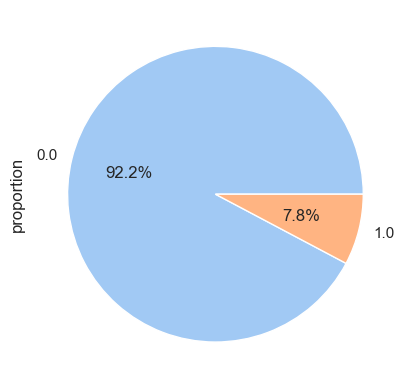

In [20]:
df['TARGET'].value_counts(normalize=True).plot(kind='pie', autopct='%.1f%%')

In [21]:
# Colonnes potentiellement inutiles, faute de variation des valeurs
df.nunique().sort_values()

REFUSED_APP_CREDIT_PERC_VAR                                                  0
FLAG_DOCUMENT_12                                                             1
PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN                             1
PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN                        1
PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN                              1
PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN                                         1
BURO_STATUS_2_MEAN_MEAN                                                      1
PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN                                    1
BURO_STATUS_3_MEAN_MEAN                                                      1
CC_NAME_CONTRACT_STATUS_nan_VAR                                              1
PREV_NAME_PRODUCT_TYPE_nan_MEAN                                              1
PREV_PRODUCT_COMBINATION_nan_MEAN                                            1
PREV_CHANNEL_TYPE_Car dealer_MEAN                   

## Préparation des données

### Fonctions de préparation

In [22]:
def reduction_taille_entier(df):
    """Transforme les entiers type 'int64' en type 'int32'."""

    df[df.columns[df.dtypes == 'int64']] = df[df.columns[df.dtypes == 'int64']].astype(dtype=np.int32, copy=False)
    return df

In [23]:
def suppression_colonnes_nan(df, taux_nan=0.8):
    """Suppression des variables avec trop de manquants"""

    df = df[df.columns[df.isna().mean() < taux_nan]]

    return df

In [24]:
def suppression_modalite_unique(df):
    """Suppression des variables avec une seule modalité"""

    col = df.columns[df.nunique() > 1].tolist()
    df = df[col]
    return df, col

In [25]:
def separation_dataframe(df, output_dir=None):
    """
    Séparation du dataframe en train/test correspondant aux dataframes du départ :
    application_train et application_test.
    Sauvegarde du dataframe_test imputé pour usage ultérieur (API/JSON).
    Renvoie dataframe_train.
    """
    output_dir = OUTPUT_DIR if output_dir is None else output_dir
    output_dir = Path(output_dir).expanduser().resolve()
    cleaned_dir = output_dir / "cleaned"
    cleaned_dir.mkdir(parents=True, exist_ok=True)

    dataframe_train = df[df["TARGET"].notnull()].copy()
    dataframe_test = df[df["TARGET"].isnull()].copy()

    dataframe_train, colonnes_une_modalite = suppression_modalite_unique(dataframe_train)
    dataframe_test = dataframe_test[colonnes_une_modalite].copy()

    dataframe_test = dataframe_test.drop(columns=["TARGET"], errors="ignore")

    imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    dataframe_test = pd.DataFrame(
        imputer.fit_transform(dataframe_test),
        index=dataframe_test.index,
        columns=dataframe_test.columns
    )

    print(
        "Dataframe avec target shape: {}, dataframe sans target shape: {}".format(
            dataframe_train.shape, dataframe_test.shape
        )
    )

    if "SK_ID_CURR" in dataframe_test.columns:
        dataframe_test["SK_ID_CURR"] = dataframe_test["SK_ID_CURR"].astype(np.int32, copy=False)

    dataframe_test.to_csv(cleaned_dir / "dataframe_test.csv", sep=",", index=False)

    del dataframe_test, df
    gc.collect()

    return dataframe_train


In [26]:
def dataframe_split(df):
    """Séparation du dataframe en 2 dataframes :
    - trainset
    - testset
    puis re-split de la target dans chacun des sets"""

    df = df.drop(columns={'SK_ID_CURR'})
    trainset , testset = train_test_split(df, test_size=0.3, random_state=39)
    X_train = trainset.drop(columns={'TARGET'})
    y_train = trainset['TARGET']
    X_test = testset.drop(columns={'TARGET'})
    y_test = testset['TARGET']
    print("Répartition de la target sur le jeu d'entraînement :")
    print(y_train.value_counts())
    print("Répartition de la target sur le jeu de test :")
    print(y_test.value_counts())
    del df, trainset, testset
    gc.collect()
    return X_train, y_train, X_test, y_test

In [27]:
def clean_infini(df):
    """Remplacement des valeurs 'infini' par des 'NaN'"""

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [28]:
def preparation(df, taux_nan=0.8):
    """Fonction finalisant le pré-processing et renvoyant les 4 jeux d'entraînement et test"""

    with timer("Remplacement des valeurs 'int64' par des 'int32'"):
        df = reduction_taille_entier(df)
    with timer("Remplacement des valeurs 'infini' par des 'NaN'"):
        df = clean_infini(df)
    with timer("Suppression des variables avec trop de manquants"):
        df = suppression_colonnes_nan(df, taux_nan=0.8)
    with timer("Séparation du dataframe initial en dataframe_train et dataframe_test\npuis sauvegarde"):
        dataframe_train = separation_dataframe(df, OUTPUT_DIR)
    with timer("Séparation du dataframe_train en trainset et testset"):
        X_train, y_train, X_test, y_test = dataframe_split(dataframe_train)


    return X_train, y_train, X_test, y_test

In [29]:
with timer("____________________________________________________\nPréparation finale des données"):
    X_train, y_train, X_test, y_test = preparation(df, taux_nan=0.8)

Remplacement des valeurs 'int64' par des 'int32' - fait en 0s
Remplacement des valeurs 'infini' par des 'NaN' - fait en 0s
Suppression des variables avec trop de manquants - fait en 0s
Dataframe avec target shape: (10000, 238), dataframe sans target shape: (10000, 237)
Séparation du dataframe initial en dataframe_train et dataframe_test
puis sauvegarde - fait en 1s
Répartition de la target sur le jeu d'entraînement :
TARGET
0.0    6435
1.0     565
Name: count, dtype: int64
Répartition de la target sur le jeu de test :
TARGET
0.0    2790
1.0     210
Name: count, dtype: int64
Séparation du dataframe_train en trainset et testset - fait en 0s
____________________________________________________
Préparation finale des données - fait en 2s


## Fonctions d'évaluation

In [30]:
def confusion(y_test, y_pred):
    """Affiche la matrice de confusion"""

    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    plt.figure(figsize = (2, 2))
    plt.title('Matrice de confusion')
    sns.heatmap(mat, annot=True, cmap="Blues", fmt='0g', cbar=False)
    plt.show()
    return mat

In [31]:
def roc_auc(y_true, y_pred_proba):
    """Trace la courbe ROC et calcule le score ROC AUC"""

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color='red', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

In [32]:
def fonction_metier(y_true, y_pred):
    """Création d'un score métier : minimisation du coût d’erreur de prédiction des FN et FP (pondération 10 contre 1)"""

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sm = (10*fn+fp)
    return sm

In [33]:
def evaluation(model):
    """Evaluation d'un modèle affichant :
        - la matrice de confusion
        - le score métier
        - la courbe ROC avec le score ROC AUC"""

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    confusion(y_test, y_pred)
    score_metier = fonction_metier(y_test, y_pred)
    print("\nScore métier =", score_metier, "\n(Le meilleur est le plus bas)")
    print("\n________________\nRapport de classification")
    print(classification_report(y_test, y_pred))
    roc_auc(y_test, y_pred_proba)
    return score_metier

## Modélisation
### Dummy classifier

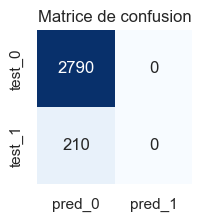


Score métier = 2100 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      2790
         1.0       0.00      0.00      0.00       210

    accuracy                           0.93      3000
   macro avg       0.47      0.50      0.48      3000
weighted avg       0.86      0.93      0.90      3000



/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

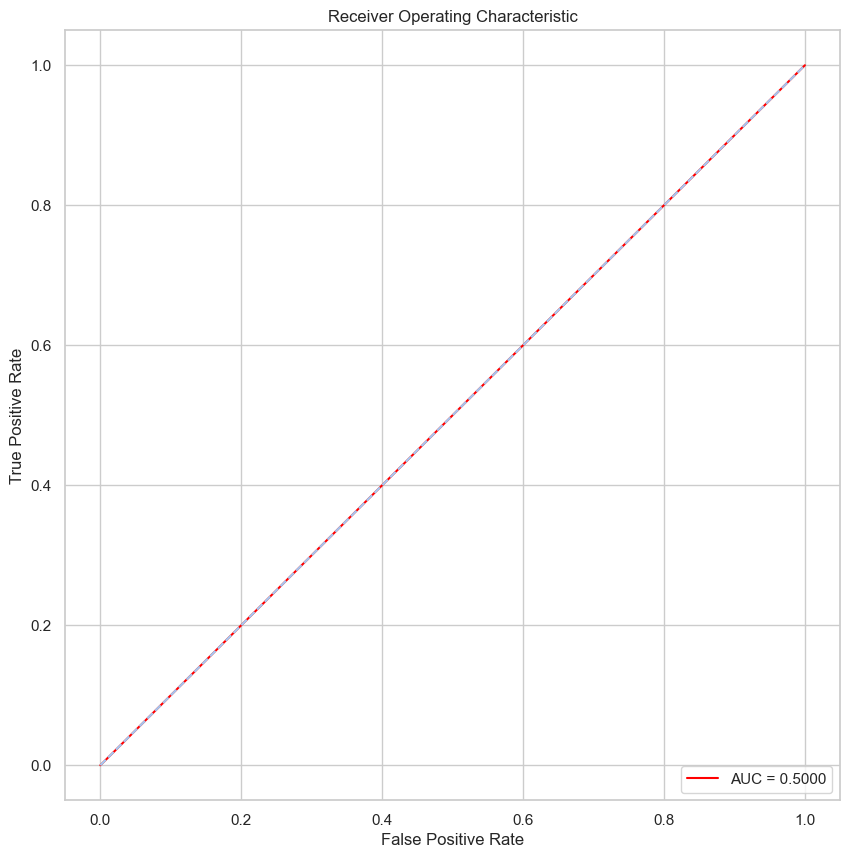

np.int64(2100)

In [34]:
estimator = DummyClassifier(strategy='most_frequent')
evaluation(estimator)

### Modèles à tester

In [35]:
preprocessor = make_pipeline(SimpleImputer(missing_values = np.nan, strategy='median'),
                             SelectKBest(f_classif, k='all'))

In [36]:
RandomForest = make_pipeline(preprocessor,
                             RandomForestClassifier(class_weight='balanced',
                                                    random_state=39,
                                                    n_jobs=-1))

LogisticRegression = make_pipeline(preprocessor,
                                   StandardScaler(),
                                   LogisticRegression(class_weight='balanced',
                                                      random_state=39,
                                                      n_jobs=-1))

XGBoost = make_pipeline(preprocessor,
                        XGBClassifier(scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
                                      random_state=39,
                                      n_jobs=-1))

LightGBM = make_pipeline(preprocessor,
                         LGBMClassifier(class_weight='balanced',
                                        random_state=39,
                                        n_jobs=-1))

In [37]:
dict_of_models = {'RandomForest': RandomForest,
                  'LogisticRegression': LogisticRegression,
                  'XGBoost': XGBoost,
                  'LightGBM': LightGBM
                 }

----------------------------------------------------------------------

Modèle : RandomForest


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


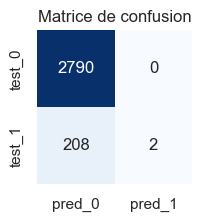


Score métier = 2080 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      2790
         1.0       1.00      0.01      0.02       210

    accuracy                           0.93      3000
   macro avg       0.97      0.50      0.49      3000
weighted avg       0.94      0.93      0.90      3000



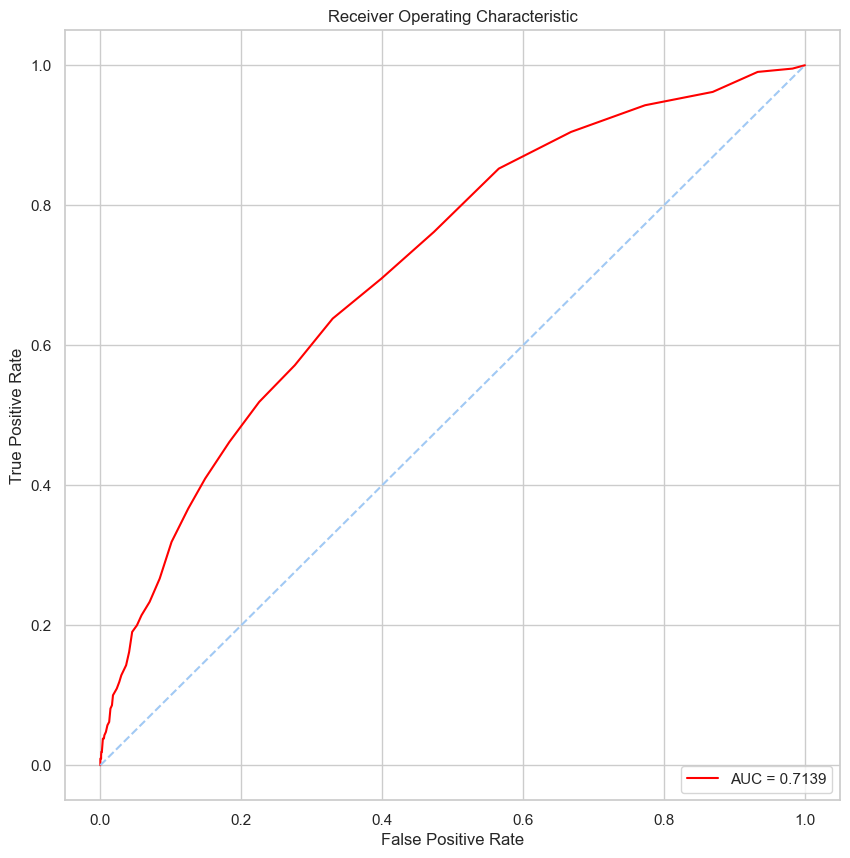

Modèle - fit, predict, scores - fait en 1s
----------------------------------------------------------------------

Modèle : LogisticRegression


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

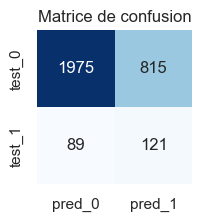


Score métier = 1705 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.81      2790
         1.0       0.13      0.58      0.21       210

    accuracy                           0.70      3000
   macro avg       0.54      0.64      0.51      3000
weighted avg       0.90      0.70      0.77      3000



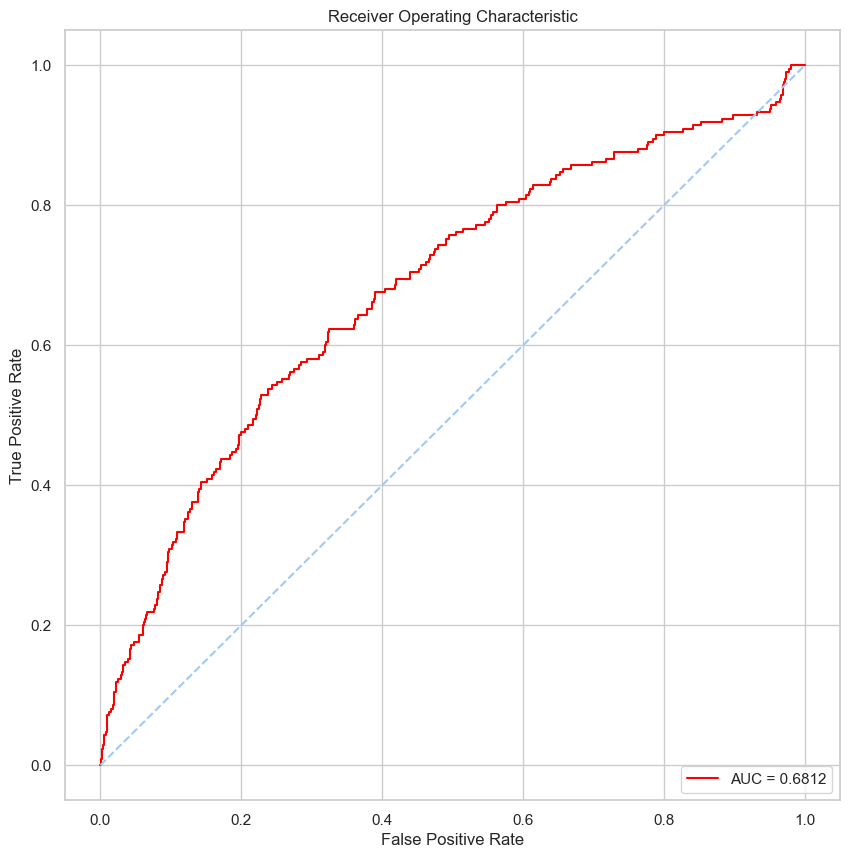

Modèle - fit, predict, scores - fait en 0s
----------------------------------------------------------------------

Modèle : XGBoost


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


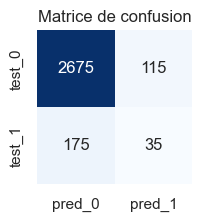


Score métier = 1865 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      2790
         1.0       0.23      0.17      0.19       210

    accuracy                           0.90      3000
   macro avg       0.59      0.56      0.57      3000
weighted avg       0.89      0.90      0.90      3000



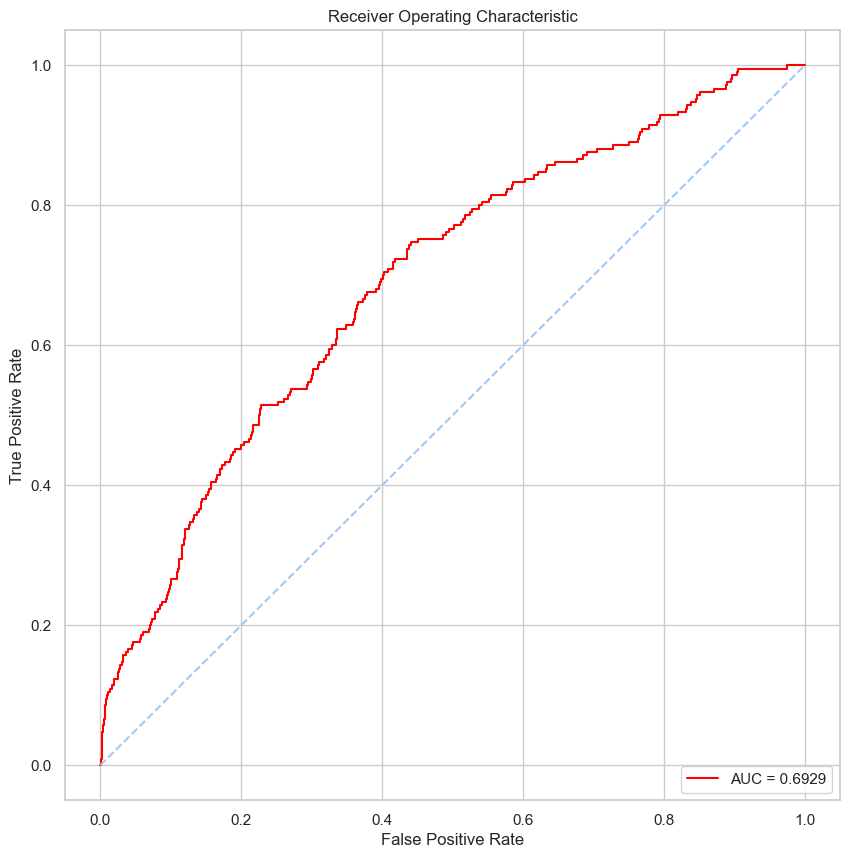

Modèle - fit, predict, scores - fait en 1s
----------------------------------------------------------------------

Modèle : LightGBM
[LightGBM] [Info] Number of positive: 565, number of negative: 6435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11262
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


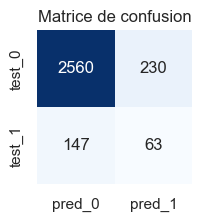


Score métier = 1700 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      2790
         1.0       0.22      0.30      0.25       210

    accuracy                           0.87      3000
   macro avg       0.58      0.61      0.59      3000
weighted avg       0.89      0.87      0.88      3000



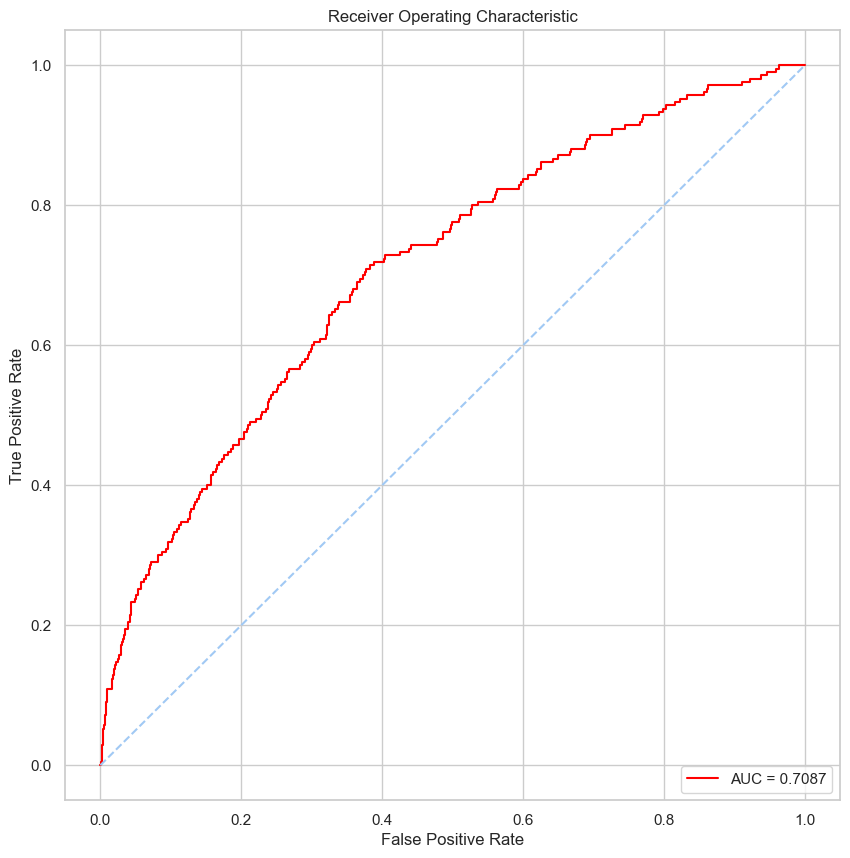

Modèle - fit, predict, scores - fait en 1s


In [38]:
for name, model in dict_of_models.items():
    with timer("Modèle - fit, predict, scores"):
        print('-'*70)
        print('\nModèle :', name)
        evaluation(model)

In [39]:
hyper_params_modeles = {'RandomForest': {'randomforestclassifier__n_estimators': [10, 200],
                                         'randomforestclassifier__criterion': ['gini', 'entropy'],
                                         'randomforestclassifier__max_depth': [3, 6]},
                        'LogisticRegression': {'logisticregression__solver': ['newton-cholesky', 'sag']},
                        'XGBoost': {'xgbclassifier__max_depth': [2, 6],
                                    'xgbclassifier__subsample': [0.1, 1],
                                    'xgbclassifier__colsample_bytree': [0.1, 1]},
                        'LightGBM': {'lgbmclassifier__n_estimators': [10, 200],
                                     'lgbmclassifier__max_depth': [2, 30],
                                     'lgbmclassifier__colsample_bytree': [0.1, 1]}
                       }

Transformation de la fonction métier en score métier à utiliser comme scoring de la validation croisée :

In [40]:
# ✅ Score métier (coût) + optimisation du seuil (sans fuite)

COST_FN = 10  # Faux négatif (mauvais client prédit bon) : perte en capital
COST_FP = 1   # Faux positif (bon client prédit mauvais) : manque à gagner

def business_cost_from_preds(y_true, y_pred):
    """Coût métier = COST_FN*FN + COST_FP*FP (plus bas = meilleur)."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return COST_FN * fn + COST_FP * fp

def find_best_threshold(y_true, y_proba, grid=None):
    """Recherche du seuil t minimisant le coût métier sur (y_true, y_proba)."""
    if grid is None:
        grid = np.linspace(0, 1, 1001)  # pas de 0.001, assez fin et rapide
    best_t, best_cost = None, float("inf")
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    for t in grid:
        y_pred = (y_proba >= t).astype(int)
        c = business_cost_from_preds(y_true, y_pred)
        if c < best_cost:
            best_cost = c
            best_t = float(t)
    return best_t, float(best_cost)

def business_scorer(estimator, X, y):
    """Scorer sklearn-compatible : retourne -min_cost (donc à maximiser). 
    Le seuil est optimisé **sur le fold de validation** (pas de leakage).
    """
    proba = estimator.predict_proba(X)[:, 1]
    _, min_cost = find_best_threshold(y, proba)
    return -min_cost


In [41]:
import os
from sklearn.model_selection import StratifiedKFold, cross_val_predict

def optimisation(model, name):
    """Optimise un modèle via GridSearchCV avec un scorer métier, puis sélectionne un seuil
    de décision 'déployable' optimisé sur des probabilités OOF (train uniquement).

    Logs MLflow:
      - params: hyperparamètres best
      - metrics: coût métier CV, coût OOF, seuil OOF, AUC, métriques pondérées, etc.
      - artefacts: threshold_config.json + modèle sklearn
    """
    # GridSearch sur TRAIN (CV interne) avec score métier (sans fuite)
    grid = GridSearchCV(
        model,
        hyper_params_modeles[name],
        scoring=business_scorer,
        cv=3,
        n_jobs=-1,
        return_train_score=True
    )
    grid.fit(X_train, y_train)

    best = grid.best_estimator_

    # 🔁 Seuil final "déployable" : optimisé sur des probabilités OOF (train uniquement)
    cv_oof = StratifiedKFold(n_splits=3, shuffle=True, random_state=39)
    proba_oof = cross_val_predict(best, X_train, y_train, cv=cv_oof, method="predict_proba", n_jobs=-1)[:, 1]
    best_threshold, best_cost_oof = find_best_threshold(y_train, proba_oof)

    # ✅ Fit final sur TRAIN complet puis évaluation sur TEST (holdout)
    best.fit(X_train, y_train)
    proba_test = best.predict_proba(X_test)[:, 1]
    pred_test = (proba_test >= best_threshold).astype(int)

    # Metrics
    best_idx = grid.best_index_
    cv_cost_train = -grid.cv_results_["mean_train_score"][best_idx]
    cv_cost_test  = -grid.cv_results_["mean_test_score"][best_idx]
    cost_test = business_cost_from_preds(y_test, pred_test)
    auc_train_oof = roc_auc_score(y_train, proba_oof)
    auc_test = roc_auc_score(y_test, proba_test)
    report = classification_report(y_test, pred_test, output_dict=True)

    # MLflow (robuste: run explicit + expérience nommée)
    mlflow.set_experiment(os.getenv("MLFLOW_EXPERIMENT_NAME", "home_credit_scoring"))
    with mlflow.start_run(run_name=name):
        mlflow.log_params(grid.best_params_)
        mlflow.log_metric("cv_score_metier_train", cv_cost_train)
        mlflow.log_metric("cv_score_metier_test", cv_cost_test)
        mlflow.log_metric("threshold_opt_oof_train", float(best_threshold))
        mlflow.log_metric("score_metier_oof_train", float(best_cost_oof))
        mlflow.log_metric("score_metier_test_optth", float(cost_test))
        mlflow.log_metric("AUC_train_oof", float(auc_train_oof))
        mlflow.log_metric("AUC_test", float(auc_test))
        mlflow.log_metric("f1_test_weighted", float(report["weighted avg"]["f1-score"]))
        mlflow.log_metric("precision_test_weighted", float(report["weighted avg"]["precision"]))
        mlflow.log_metric("recall_test_weighted", float(report["weighted avg"]["recall"]))

        mlflow.log_dict(
            {"threshold": float(best_threshold), "cost_fn": float(COST_FN), "cost_fp": float(COST_FP)},
            "threshold_config.json"
        )

        mlflow.sklearn.log_model(best, "model")

    # Affichage
    print("\nRésultats de la validation croisée (coût métier, plus bas = meilleur) :")
    print(" - CV coût (train):", round(cv_cost_train, 2))
    print(" - CV coût (test) :", round(cv_cost_test, 2))
    print(" - Seuil optimal (OOF train) :", best_threshold)
    print(" - Coût OOF train :", best_cost_oof)
    print(" - Coût TEST (avec seuil OOF) :", cost_test)
    print(" - AUC OOF train :", round(auc_train_oof, 4))
    print(" - AUC TEST :", round(auc_test, 4))
    print("\nMeilleurs hyper-paramètres :", grid.best_params_)
    print("\n________________\nRapport de classification (TEST)")
    print(classification_report(y_test, pred_test))
    confusion(y_test, pred_test)


In [42]:
# ℹ️ Rappel MLflow (tracking local) – diagnostic
import mlflow
print("✅ MLflow tracking uri:", mlflow.get_tracking_uri())


✅ MLflow tracking uri: file:///Users/andersoncarbeti/Projet_7_final/Projet_7_final/mlruns


------------------------------------------------------------------------------------------
RandomForest


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_sel


Résultats de la validation croisée (coût métier, plus bas = meilleur) :
 - CV coût (train): 2042.0
 - CV coût (test) : 1321.0
 - Seuil optimal (OOF train) : 0.496
 - Coût OOF train : 3962.0
 - Coût TEST (avec seuil OOF) : 1683
 - AUC OOF train : 0.7164
 - AUC TEST : 0.7133

Meilleurs hyper-paramètres : {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 200}

________________
Rapport de classification (TEST)
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82      2790
         1.0       0.13      0.57      0.22       210

    accuracy                           0.71      3000
   macro avg       0.54      0.65      0.52      3000
weighted avg       0.90      0.71      0.78      3000



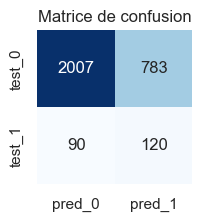

------------------------------------------------------------------------------------------
LogisticRegression


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn


Résultats de la validation croisée (coût métier, plus bas = meilleur) :
 - CV coût (train): 1900.67
 - CV coût (test) : 1330.33
 - Seuil optimal (OOF train) : 0.529
 - Coût OOF train : 4074.0
 - Coût TEST (avec seuil OOF) : 1673
 - AUC OOF train : 0.7045
 - AUC TEST : 0.6817

Meilleurs hyper-paramètres : {'logisticregression__solver': 'newton-cholesky'}

________________
Rapport de classification (TEST)
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83      2790
         1.0       0.14      0.55      0.22       210

    accuracy                           0.73      3000
   macro avg       0.55      0.64      0.53      3000
weighted avg       0.90      0.73      0.79      3000



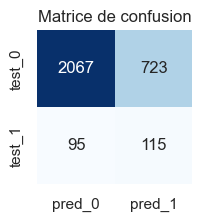

------------------------------------------------------------------------------------------
XGBoost


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn


Résultats de la validation croisée (coût métier, plus bas = meilleur) :
 - CV coût (train): 1087.33
 - CV coût (test) : 1324.0
 - Seuil optimal (OOF train) : 0.402
 - Coût OOF train : 3952.0
 - Coût TEST (avec seuil OOF) : 1616
 - AUC OOF train : 0.7273
 - AUC TEST : 0.733

Meilleurs hyper-paramètres : {'xgbclassifier__colsample_bytree': 1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__subsample': 1}

________________
Rapport de classification (TEST)
              precision    recall  f1-score   support

         0.0       0.97      0.66      0.78      2790
         1.0       0.13      0.69      0.22       210

    accuracy                           0.66      3000
   macro avg       0.55      0.67      0.50      3000
weighted avg       0.91      0.66      0.74      3000



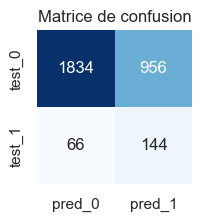

------------------------------------------------------------------------------------------
LightGBM


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Total Bins 11076
[LightGBM] [I

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [bin

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: U

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] [bin

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/sit

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightG

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/v

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: U

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_sel

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[Light

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: U

[LightGBM] [Info] Number of positive: 565, number of negative: 6435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11262
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklea

[LightGBM] [Info] Number of positive: 565, number of negative: 6435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11262
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

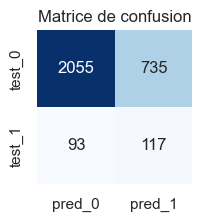

In [43]:
# Assure que dict_of_models existe ; le recrée à partir des estimateurs disponibles si nécessaire
if 'dict_of_models' not in globals():
    candidate_names = ['RandomForest', 'LogisticRegression', 'XGBoost', 'LightGBM']
    dict_of_models = {n: globals()[n] for n in candidate_names if n in globals()}
    if not dict_of_models:
        raise NameError("dict_of_models introuvable et aucun estimateur présent (ex: RandomForest, LogisticRegression, XGBoost, LightGBM). Exécute les cellules définissant les modèles.")

for nom, modele in dict_of_models.items():
    print('-'*90)
    print(nom)
    optimisation(modele, nom)

### Création d'une expérience MLFlow

In [44]:
# ℹ️ MLflow – s'assure que l'expérience existe (safe à relancer)
import os
import mlflow

EXPERIMENT_NAME = os.getenv("MLFLOW_EXPERIMENT_NAME", "home_credit_scoring")
mlflow.set_experiment(EXPERIMENT_NAME)
exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

print("✅ MLflow experiment:", EXPERIMENT_NAME)
print("✅ MLflow experiment_id:", exp.experiment_id if exp else None)


✅ MLflow experiment: home_credit_scoring
✅ MLflow experiment_id: 334112140175451421


In [45]:
runs = mlflow.search_runs(experiment_ids=[exp.experiment_id], max_results=50)
runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.cv_score_metier_train,metrics.AUC_test,metrics.AUC_train_oof,metrics.score_metier_test_optth,metrics.cv_score_metier_test,metrics.threshold_opt_oof_train,metrics.recall_test_weighted,metrics.f1_test_weighted,metrics.precision_test_weighted,metrics.score_metier_oof_train,params.lgbmclassifier__colsample_bytree,params.lgbmclassifier__n_estimators,params.lgbmclassifier__max_depth,params.xgbclassifier__max_depth,params.xgbclassifier__subsample,params.xgbclassifier__colsample_bytree,params.logisticregression__solver,params.randomforestclassifier__max_depth,params.randomforestclassifier__criterion,params.randomforestclassifier__n_estimators,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type
0,a4c174e477c5477a92430ebd459f36c1,334112140175451421,FINISHED,file:///Users/andersoncarbeti/Projet_7_final/u...,2026-01-30 05:35:31.015000+00:00,2026-01-30 05:35:34.543000+00:00,2389.333333,0.711906,0.718021,1665.0,1289.000000,0.527,0.724000,0.789482,0.899347,3955.0,1,10,2,None,None,None,None,None,None,None,LightGBM,Projet7_scoring_jury_ready_LOCAL_jury_pack_v4....,andersoncarbeti,NOTEBOOK
1,444aaedddf3349f380e1567b21f3bf58,334112140175451421,FINISHED,file:///Users/andersoncarbeti/Projet_7_final/u...,2026-01-30 05:34:52.173000+00:00,2026-01-30 05:34:55.365000+00:00,1087.333333,0.732956,0.727255,1616.0,1324.000000,0.402,0.659333,0.742733,0.906858,3952.0,None,None,None,2,1,1,None,None,None,None,XGBoost,Projet7_scoring_jury_ready_LOCAL_jury_pack_v4....,andersoncarbeti,NOTEBOOK
2,d655d08d980146e49717d69d93c46263,334112140175451421,FINISHED,file:///Users/andersoncarbeti/Projet_7_final/u...,2026-01-30 05:34:18.313000+00:00,2026-01-30 05:34:21.293000+00:00,1900.666667,0.681679,0.704478,1673.0,1330.333333,0.529,0.727333,0.791740,0.898741,4074.0,None,None,None,None,None,None,newton-cholesky,None,None,None,LogisticRegression,Projet7_scoring_jury_ready_LOCAL_jury_pack_v4....,andersoncarbeti,NOTEBOOK
3,f36c305e16b64921856f2e4a806b5ebc,334112140175451421,FINISHED,file:///Users/andersoncarbeti/Projet_7_final/u...,2026-01-30 05:33:59.924000+00:00,2026-01-30 05:34:05.371000+00:00,2042.000000,0.713318,0.716407,1683.0,1321.000000,0.496,0.709000,0.778962,0.899388,3962.0,None,None,None,None,None,None,None,3,entropy,200,RandomForest,Projet7_scoring_jury_ready_LOCAL_jury_pack_v4....,andersoncarbeti,NOTEBOOK


In [46]:
import re, unicodedata

def mlflow_safe_name(name: str) -> str:
    """Nettoie un nom (accents / caractères spéciaux) pour MLflow."""
    s = unicodedata.normalize("NFKD", str(name))
    s = s.encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"[^0-9a-zA-Z_\-\. :/ ]+", "_", s)
    return s


In [47]:
mlflow.end_run()
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict

MODEL_NAME = "home_credit_default_model"

# 🔎 Optimisation poussée sur LightGBM (RandomizedSearchCV) avec MLflow
with mlflow.start_run(experiment_id=exp.experiment_id, run_name="LightGBM-RandomizedSearch"):
    grid = RandomizedSearchCV(
        estimator=LightGBM,
        param_distributions=hyper_params_modeles["LightGBM"],
        scoring=business_scorer,   # score métier avec seuil optimisé dans les folds
        cv=3,
        n_iter=20,
        n_jobs=-1,
        return_train_score=True,
        random_state=39,
    )
    grid.fit(X_train, y_train)

    best = grid.best_estimator_

    # 🔁 Seuil final "déployable" : optimisé sur OOF train uniquement
    cv_oof = StratifiedKFold(n_splits=3, shuffle=True, random_state=39)
    proba_oof = cross_val_predict(best, X_train, y_train, cv=cv_oof, method="predict_proba", n_jobs=-1)[:, 1]
    best_threshold, best_cost_oof = find_best_threshold(y_train, proba_oof)

    # ✅ Fit final sur TRAIN complet puis évaluation sur TEST (holdout)
    best.fit(X_train, y_train)
    proba_test = best.predict_proba(X_test)[:, 1]
    pred_test = (proba_test >= best_threshold).astype(int)

    # Metrics (valeurs lisibles côté "coût" → on inverse le signe du scorer)
    best_idx = grid.best_index_
    cv_cost_train = -grid.cv_results_["mean_train_score"][best_idx]
    cv_cost_test = -grid.cv_results_["mean_test_score"][best_idx]
    test_cost = business_cost_from_preds(y_test, pred_test)
    auc_train_oof = roc_auc_score(y_train, proba_oof)
    auc_test = roc_auc_score(y_test, proba_test)
    report = classification_report(y_test, pred_test, output_dict=True)

    # Logs MLflow
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("cv_score_metier_train", cv_cost_train)
    mlflow.log_metric("cv_score_metier_test", cv_cost_test)
    mlflow.log_metric("threshold_opt_oof_train", best_threshold)
    mlflow.log_metric("score_metier_oof_train", best_cost_oof)
    mlflow.log_metric("score_metier_test_optth", test_cost)
    mlflow.log_metric("AUC_train_oof", auc_train_oof)
    mlflow.log_metric("AUC_test", auc_test)
    mlflow.log_metric("f1_test_weighted", report["weighted avg"]["f1-score"])
    mlflow.log_metric("precision_test_weighted", report["weighted avg"]["precision"])
    mlflow.log_metric("recall_test_weighted", report["weighted avg"]["recall"])

    mlflow.log_dict(
        {"threshold": best_threshold, "cost_fn": COST_FN, "cost_fp": COST_FP},
        "threshold_config.json"
    )

    mlflow.sklearn.log_model(best, "model")

    # --- Registry (enregistrement) ---
    # On enregistre le modèle pour historiser une version dans le Registry.
    # L’alias "champion" est (re)défini plus bas, après comparaison de TOUS les runs.
    mlflow.sklearn.log_model(best, "model", registered_model_name=MODEL_NAME)

    print("✅ Best params:", grid.best_params_)
    print("✅ CV coût métier (test):", round(cv_cost_test, 2))
    print("✅ Seuil optimal (OOF train):", best_threshold)
    print("✅ Coût métier TEST (seuil OOF):", test_cost)
    print("✅ AUC TEST:", round(auc_test, 4))



/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/and

[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: U

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the 

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightG

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, num

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: U

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-pa

[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 93 114 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11037
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 186
[LightGBM] [Info] [binar

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11073
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: U

[LightGBM] [Info] Number of positive: 565, number of negative: 6435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11262
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/30 06:36:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[LightGBM] [Info] Number of positive: 565, number of negative: 6435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11262
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Successfully registered model 'home_credit_default_model'.
Created version '1' of model 'home_credit_default_model'.


## Optimisation supplémentaire avec le seuil de décision
A présent, la liste des runs de l'expérience - visible avec **MLFlow UI** - fournit le meilleur modèle et ses hyperparamètres.

Je le charge afin de déterminer le seuil de décision qui fournira le meilleur score métier.

In [49]:
import pandas as pd

# 📋 Lister les métriques disponibles via MLflow (pas besoin de parser le dossier mlruns)
runs = mlflow.search_runs(experiment_ids=[exp.experiment_id], max_results=50)
print("Colonnes metrics trouvées :")
for c in sorted([c for c in runs.columns if c.startswith("metrics.")]):
    print("-", c)


Colonnes metrics trouvées :
- metrics.AUC_test
- metrics.AUC_train_oof
- metrics.Score metier Validation Train
- metrics.cv_score_metier_test
- metrics.cv_score_metier_train
- metrics.f1_test_weighted
- metrics.precision_test_weighted
- metrics.recall_test_weighted
- metrics.score_metier_oof_train
- metrics.score_metier_test_optth
- metrics.threshold_opt_oof_train


In [50]:

# 📊 Comparatif runs (AUC vs coût métier) — support "jury-proof"
import pandas as pd
import mlflow

runs = mlflow.search_runs(experiment_ids=[exp.experiment_id], max_results=200)

cols = [
    "run_id", "tags.mlflow.runName",
    "metrics.AUC_test",
    "metrics.score_metier_test_optth",
    "metrics.cv_score_metier_test",
    "metrics.cv_score_metier_train",
]
cols = [c for c in cols if c in runs.columns]
summary = runs[cols].copy()

if "metrics.score_metier_test_optth" in summary.columns:
    summary = summary.sort_values("metrics.score_metier_test_optth", ascending=True)

summary_path = OUTPUT_DIR / "runs_summary.csv"
summary.to_csv(summary_path, index=False)
display(summary.head(15))
print("✅ Saved:", summary_path)

if "metrics.score_metier_test_optth" in runs.columns:
    best_by_cost = runs.sort_values("metrics.score_metier_test_optth", ascending=True).iloc[0]
    print("\n🏆 Best by business cost (test):")
    print("run_name:", best_by_cost.get("tags.mlflow.runName"))
    print("run_id:", best_by_cost.get("run_id"))
    print("cost_test:", best_by_cost.get("metrics.score_metier_test_optth"))
    print("auc_test:", best_by_cost.get("metrics.AUC_test"))


,run_id,tags.mlflow.runName,metrics.score_metier_test_optth,metrics.cv_score_metier_test,metrics.cv_score_metier_train
3,444aaedddf3349f380e1567b21f3bf58,XGBoost,1616.0,1324.000000,1087.333333
0,43aed86e5d1e415bb70bc11e18f64e2f,LightGBM-RandomizedSearch,1665.0,1289.000000,2389.333333
2,a4c174e477c5477a92430ebd459f36c1,LightGBM,1665.0,1289.000000,2389.333333
4,d655d08d980146e49717d69d93c46263,LogisticRegression,1673.0,1330.333333,1900.666667
5,f36c305e16b64921856f2e4a806b5ebc,RandomForest,1683.0,1321.000000,2042.000000
1,fabf41e7ecb6439d90bd570370d7fec6,able-calf-677,NaN,NaN,NaN


✅ Saved: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/runs_summary.csv

🏆 Best by business cost (test):
run_name: XGBoost
run_id: 444aaedddf3349f380e1567b21f3bf58
cost_test: 1616.0
auc_test: None


## Justification du champion (obligatoire en soutenance)

**Fait important :** il peut arriver qu'un modèle ait une meilleure AUC mais un **moins bon coût métier**, ou inversement.  
Le jury attend une décision **argumentée**.

### Règle de décision recommandée
- **Si l'objectif prioritaire est le coût métier** (FN/FP pondérés), alors le champion doit être le meilleur sur `score_metier_test_optth` (ou à défaut sur le coût OOF/CV).
- **Si l'objectif prioritaire est la robustesse / stabilité / déploiement**, tu peux choisir un modèle légèrement moins bon sur un test ponctuel, mais :
  - plus stable (variance plus faible),
  - plus simple à monitorer,
  - plus reproductible,
  - meilleur en CV/OOF.

➡️ Le tableau `runs_summary.csv` exporté plus haut sert de **preuve** dans le dossier `outputs/`.


In [51]:
# Charger le meilleur modèle + son seuil (depuis MLflow)

MODEL_NAME = "home_credit_default_model"

# 1) Identifier le meilleur run (coût métier test minimal)
runs = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    order_by=["metrics.score_metier_test_optth ASC"],
    max_results=50,
).dropna(subset=["metrics.score_metier_test_optth"]).reset_index(drop=True)

best_run_id = runs.loc[0, "run_id"]
best_cost_test = runs.loc[0, "metrics.score_metier_test_optth"]
print("🏆 Best run_id:", best_run_id)
print("🏆 Best cost_test:", best_cost_test)

# 2) Charger le modèle (Registry alias -> fallback run artifact)
perfect_model = None
try:
    model_uri = f"models:/{MODEL_NAME}@champion"
    perfect_model = mlflow.sklearn.load_model(model_uri)
    print("✅ Loaded from Registry:", model_uri)
except Exception as e:
    print("⚠️ Registry load failed, fallback to run artifact:", e)
    model_uri = f"runs:/{best_run_id}/model"
    perfect_model = mlflow.sklearn.load_model(model_uri)
    print("✅ Loaded from run:", model_uri)

# 3) Charger le seuil utilisé (artifact threshold_config.json)
best_threshold = None
try:
    import json
    from mlflow.artifacts import download_artifacts
    th_path = download_artifacts(run_id=best_run_id, artifact_path="threshold_config.json")
    with open(th_path, "r", encoding="utf-8") as f:
        th_cfg = json.load(f)
    best_threshold = float(th_cfg["threshold"])
    print("✅ Threshold loaded:", best_threshold, "| cfg:", th_cfg)
except Exception as e:
    print("⚠️ threshold_config.json introuvable -> on recalculera le seuil si nécessaire. Détail:", e)


🏆 Best run_id: 444aaedddf3349f380e1567b21f3bf58
🏆 Best cost_test: 1616.0
✅ Loaded from Registry: models:/home_credit_default_model@champion


✅ Threshold loaded: 0.402 | cfg: {'threshold': 0.402, 'cost_fn': 10.0, 'cost_fp': 1.0}


In [ ]:
# ✅ (Re)définition du "champion" à partir du meilleur run (coût métier minimal)
# Objectif : aligner le Registry + l’API avec le meilleur modèle observé.

from mlflow.tracking import MlflowClient
import mlflow

MODEL_NAME = "home_credit_default_model"
ALIAS = "champion"
client = MlflowClient()

# Enregistrer le meilleur modèle (runs:/.../model) dans le Registry
model_uri = f"runs:/{best_run_id}/model"
mv = mlflow.register_model(model_uri=model_uri, name=MODEL_NAME)

# Appliquer l’alias "champion" sur cette version
client.set_registered_model_alias(MODEL_NAME, ALIAS, mv.version)
print(f"✅ Registry mis à jour : {MODEL_NAME} v{mv.version} (alias={ALIAS}) depuis run_id={best_run_id}")


In [48]:
# 📦 Export local des artefacts du modèle champion (optionnel)
# Utile si tu veux archiver le modèle en dehors de MLflow.

from mlflow.tracking import MlflowClient
import mlflow
from pathlib import Path

client = MlflowClient()
MODEL_NAME = "home_credit_default_model"
ALIAS = "champion"

mv = client.get_model_version_by_alias(MODEL_NAME, ALIAS)

local_dir = Path("artifacts/model_champion")
local_dir.mkdir(parents=True, exist_ok=True)

mlflow.artifacts.download_artifacts(
    artifact_uri=mv.source,
    dst_path=str(local_dir)
)

print("✅ Artefacts du champion exportés vers :", local_dir)


✅ Modèle exporté vers : artifacts/model


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 81 114 182 194 205] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/fea

[LightGBM] [Info] Number of positive: 376, number of negative: 4290
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Number of positive: 377, number of negative: 4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11066
[LightGBM] [Info] Total Bins 11046
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 190
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM

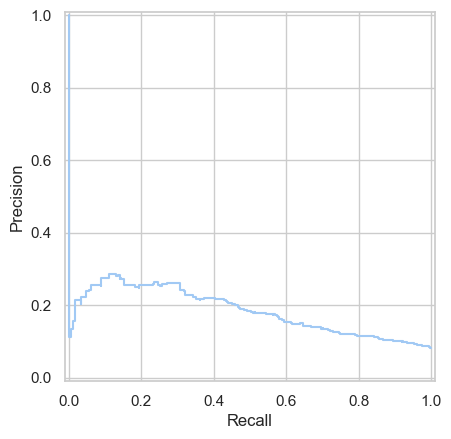

In [52]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# ✅ Seuil de décision "déployable" : optimisé sur OOF train (pas sur le test)
cv_oof = StratifiedKFold(n_splits=3, shuffle=True, random_state=39)
proba_oof = cross_val_predict(perfect_model, X_train, y_train, cv=cv_oof, method="predict_proba", n_jobs=-1)[:, 1]

best_threshold, best_cost_oof = find_best_threshold(y_train, proba_oof)
print("🔎 Seuil optimal (OOF train):", best_threshold)
print("🔎 Coût métier OOF train:", best_cost_oof)

# Courbe Precision-Recall (sur OOF train)
precision, recall, thr = precision_recall_curve(y_train, proba_oof)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


### Décision binaire = probabilité + seuil

Le modèle renvoie une probabilité de défaut.  
La classe (accordé/refusé) est obtenue en appliquant un **seuil optimisé sur le train** (OOF) pour minimiser le coût métier.

In [53]:
def model_final(model, X, threshold=0.5):
    """Renvoie la classe (0/1) en fonction de la probabilité et du seuil."""
    return (model.predict_proba(X)[:, 1] >= threshold).astype(int)


Seuil utilisé: 0.527
Coût métier TEST: 1665
AUC TEST: 0.7119056152927121
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83      2790
         1.0       0.14      0.56      0.22       210

    accuracy                           0.72      3000
   macro avg       0.55      0.65      0.53      3000
weighted avg       0.90      0.72      0.79      3000



/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


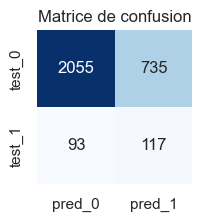

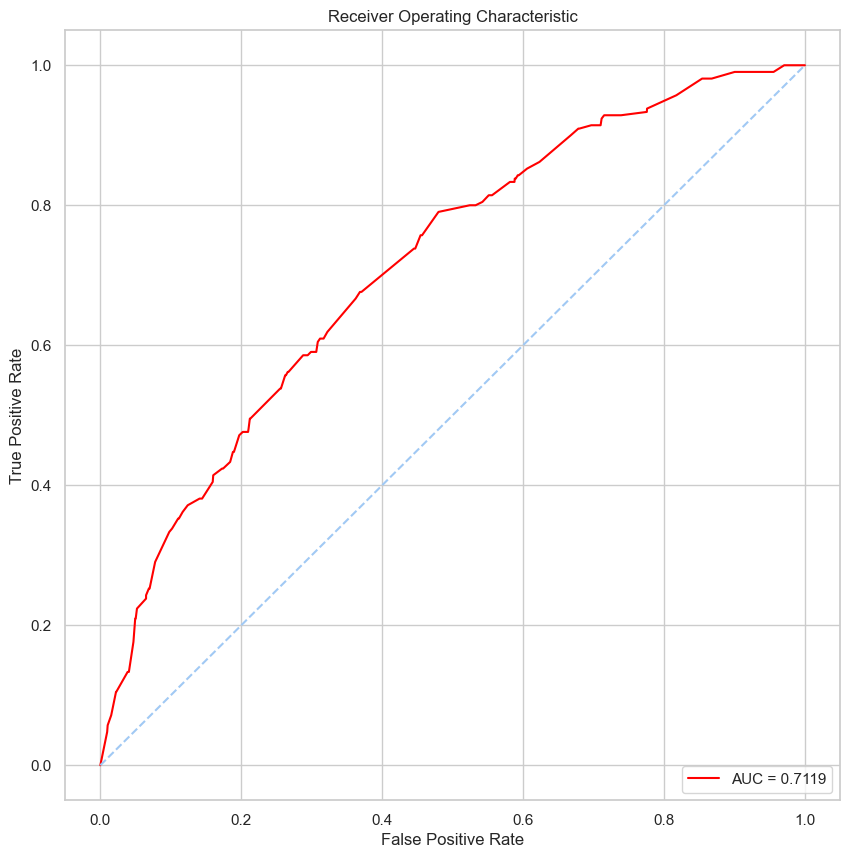

0.7119056152927121

In [54]:
# Évaluation finale sur le holdout test
# - seuil = chargé depuis MLflow (threshold_config.json)
# - sinon recalculé sur OOF train (sans toucher au test)

if best_threshold is None:
    from sklearn.model_selection import StratifiedKFold, cross_val_predict
    cv_oof = StratifiedKFold(n_splits=3, shuffle=True, random_state=39)
    proba_oof = cross_val_predict(perfect_model, X_train, y_train, cv=cv_oof, method="predict_proba", n_jobs=-1)[:, 1]
    best_threshold, _ = find_best_threshold(y_train, proba_oof)
    print("ℹ️ Threshold recalculé (OOF train):", best_threshold)

proba_test = perfect_model.predict_proba(X_test)[:, 1]
pred_test = model_final(perfect_model, X_test, threshold=best_threshold)

print("Seuil utilisé:", best_threshold)
print("Coût métier TEST:", business_cost_from_preds(y_test, pred_test))
print("AUC TEST:", roc_auc_score(y_test, proba_test))
print(classification_report(y_test, pred_test))

confusion(y_test, pred_test)
roc_auc(y_test, proba_test)


## Sérialisation de la pipeline

## Fonction d'inférence unique (API / Streamlit ready)

Objectif : une seule fonction de référence pour :
- charger le **modèle champion** (alias MLflow)
- charger le **seuil optimisé**
- produire `proba_default` + `decision`
- exporter un CSV de scoring


In [55]:

from dataclasses import dataclass
from typing import Optional
import json
import pandas as pd
import mlflow
from mlflow.tracking import MlflowClient
from pathlib import Path

@dataclass
class ChampionBundle:
    model: object
    threshold: float
    cost_fn: float
    cost_fp: float
    model_uri: str
    run_id: Optional[str] = None

def load_champion_bundle(
    model_name: str = "home_credit_default_model",
    alias: str = "champion",
    fallback_run_id: Optional[str] = None,
    default_threshold: float = 0.5,
) -> ChampionBundle:
    '''
    Charge le modèle champion depuis le MLflow Model Registry (alias),
    ainsi que sa configuration de seuil (artifact threshold_config.json si disponible).

    - Compatible tracking local (FileStore).
    - Fallback : si alias/registry indisponible, charge depuis un run_id.
    '''
    client = MlflowClient()

    # 1) Charger le modèle (alias) — fallback vers run_id si besoin
    model_uri = f"models:/{model_name}@{alias}"
    run_id = None
    try:
        model = mlflow.sklearn.load_model(model_uri)
        try:
            mv = client.get_model_version_by_alias(model_name, alias)
            run_id = mv.run_id
        except Exception:
            run_id = None
    except Exception as e:
        if fallback_run_id is None:
            raise RuntimeError(
                f"Impossible de charger le modèle via {model_uri} et aucun fallback_run_id fourni.\n"
                f"Détail: {e}"
            )
        model_uri = f"runs:/{fallback_run_id}/model"
        model = mlflow.sklearn.load_model(model_uri)
        run_id = fallback_run_id

    # 2) Charger le threshold_config.json si présent
    threshold = default_threshold
    cost_fn, cost_fp = 10.0, 1.0
    if run_id is not None:
        try:
            from mlflow.artifacts import download_artifacts
            th_path = download_artifacts(run_id=run_id, artifact_path="threshold_config.json")
            with open(th_path, "r", encoding="utf-8") as f:
                cfg = json.load(f)
            threshold = float(cfg.get("threshold", threshold))
            cost_fn = float(cfg.get("cost_fn", cost_fn))
            cost_fp = float(cfg.get("cost_fp", cost_fp))
        except Exception as e:
            print("⚠️ threshold_config.json introuvable pour ce run_id -> seuil par défaut utilisé.", e)

    return ChampionBundle(
        model=model,
        threshold=threshold,
        cost_fn=cost_fn,
        cost_fp=cost_fp,
        model_uri=model_uri,
        run_id=run_id,
    )

def predict_proba_and_decision(bundle: ChampionBundle, X_features: pd.DataFrame) -> pd.DataFrame:
    '''
    Inférence standard :
    - attend des features déjà préprocessées (mêmes colonnes que l'entraînement)
    - renvoie un DataFrame avec proba + décision (seuil du bundle)
    '''
    proba = bundle.model.predict_proba(X_features)[:, 1]
    decision = (proba >= bundle.threshold).astype(int)

    return pd.DataFrame(
        {"proba_default": proba, "decision": decision},
        index=X_features.index,
    )

def export_scoring_csv(scoring_df: pd.DataFrame, path: Path) -> Path:
    path.parent.mkdir(parents=True, exist_ok=True)
    scoring_df.to_csv(path, index=True)
    return path

# ✅ Chargement bundle champion (utilise l'alias "champion")
bundle = load_champion_bundle(
    model_name=MODEL_NAME,
    alias="champion",
    fallback_run_id=best_run_id if "best_run_id" in globals() else None,
)
print("✅ Champion loaded:", bundle.model_uri, "| run_id:", bundle.run_id)
print("✅ Threshold:", bundle.threshold, "| cost_fn:", bundle.cost_fn, "| cost_fp:", bundle.cost_fp)

# Exemple : scoring sur X_test (features préprocessées)
scoring_test = predict_proba_and_decision(bundle, X_test)
scoring_path = OUTPUT_DIR / "scoring_holdout_test.csv"
export_scoring_csv(scoring_test, scoring_path)
print("✅ Export scoring:", scoring_path)
display(scoring_test.head())


✅ Champion loaded: models:/home_credit_default_model@champion | run_id: 43aed86e5d1e415bb70bc11e18f64e2f
✅ Threshold: 0.527 | cost_fn: 10.0 | cost_fp: 1.0
✅ Export scoring: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/scoring_holdout_test.csv



/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,proba_default,decision
9229,0.465807,0
7476,0.613971,1
2702,0.381914,0
3941,0.375529,0
3540,0.330868,0


In [56]:
# 💾 Sauvegarde de la pipeline dans Drive
from pathlib import Path
pipeline_path = MODELS_DIR / "pipeline_lgbm.joblib"
joblib.dump(perfect_model, str(pipeline_path))
print("✅ Pipeline sauvegardée :", pipeline_path)


✅ Pipeline sauvegardée : /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/models/pipeline_lgbm.joblib


## Interprétation des prédictions à l'aide des SHAP Values

In [57]:
# (Nettoyé) Diagnostic chemins supprimé pour version jury-ready.


In [58]:

# ✅ Garde-fou : s'assurer que dataframe_test.csv existe à l'emplacement attendu (CLEAN_DIR)
# - soit généré par le notebook
# - soit fourni manuellement (ex: fichier à la racine du projet)

from pathlib import Path
import shutil

candidate_paths = [
    DF_TEST_PATH,
    ROOT / "dataframe_test.csv",
    DATA_DIR / "dataframe_test.csv",
    CLEAN_DIR / "dataframe_test.csv",
]
if not DF_TEST_PATH.exists():
    for p in candidate_paths[1:]:
        if p.exists():
            shutil.copy2(str(p), str(DF_TEST_PATH))
            print("✅ Copied dataframe_test.csv from", p, "to", DF_TEST_PATH)
            break

if not DF_TEST_PATH.exists():
    raise FileNotFoundError(
        f"dataframe_test.csv introuvable.\n"
        f"➡️ Attendu : {DF_TEST_PATH}\n"
        f"➡️ Options : place-le dans {CLEAN_DIR} ou à la racine du projet."
    )


In [59]:
# SHAP: échantillon "production" (application_test)
df_test_path = DF_TEST_PATH
application_test = pd.read_csv(df_test_path)

n = 100
application_test_sample = application_test.sample(n=min(n, len(application_test)), random_state=39).copy()
print("Sample size:", len(application_test_sample))


Sample size: 100


In [60]:
# SHAP (global + local) — calcul sur un échantillon pour rester rapide

# Features à expliquer (retirer ID / colonnes non-features si présentes)
drop_cols = [c for c in ["SK_ID_CURR", "TARGET", "threshold"] if c in application_test_sample.columns]
X_explain = application_test_sample.drop(columns=drop_cols, errors="ignore").copy()

# Background = échantillon du train (référence)
bg = X_train.sample(n=min(200, len(X_train)), random_state=39).copy()

with timer("SHAP explainer + values"):
    f = lambda x: perfect_model.predict_proba(x)[:, 1]
    explainer = shap.Explainer(f, bg)
    shap_values = explainer(X_explain, max_evals=2000)

# Sauvegarde des plots (utile pour la soutenance)
from pathlib import Path
shap_dir = REPORTS_DIR / "shap"
shap_dir.mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt
plt.figure()
shap.summary_plot(shap_values, max_display=10, show=False)
plt.tight_layout()
summary_path = shap_dir / "shap_summary.png"
plt.savefig(str(summary_path), dpi=160, bbox_inches="tight")
plt.close()
print("✅ Saved:", summary_path)

# Local explanation (1er client de l'échantillon)
plt.figure()
shap.plots.waterfall(shap_values[0], max_display=10, show=False)
waterfall_path = shap_dir / "shap_waterfall_0.png"
plt.savefig(str(waterfall_path), dpi=160, bbox_inches="tight")
plt.close()
print("✅ Saved:", waterfall_path)


/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: U

SHAP explainer + values - fait en 31s
✅ Saved: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/reports/shap/shap_summary.png
✅ Saved: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/reports/shap/shap_waterfall_0.png


In [61]:
from pathlib import Path

# Exports utiles pour l'API / le dashboard de test
base = Path(OUTPUT_DIR)

out1 = base / "data" / "echantillon_clients.csv"
out2 = base / "Streamlit" / "echantillon_clients.csv"

out1.parent.mkdir(parents=True, exist_ok=True)
out2.parent.mkdir(parents=True, exist_ok=True)

# Ajouter le seuil utilisé (pour l'API côté client)
if best_threshold is None:
    print("⚠️ best_threshold None -> pas ajouté au CSV")
else:
    application_test["threshold"] = float(best_threshold)

application_test.to_csv(out1, index=False)
application_test.to_csv(out2, index=False)

print("✅ Saved:", out1)
print("✅ Saved:", out2)


✅ Saved: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/data/echantillon_clients.csv
✅ Saved: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/Streamlit/echantillon_clients.csv


In [62]:
# Échantillon de dispersion (train/test split) pour visualisations dans l'app de test
df_disp = X_test.copy()
df_disp = df_disp.reset_index(drop=True)
y_disp = pd.Series(y_test).reset_index(drop=True)
df_disp["TARGET"] = y_disp

echantillon_dispersion = df_disp.sample(n=min(2000, len(df_disp)), random_state=39)
print(echantillon_dispersion["TARGET"].value_counts())


TARGET
0.0    1860
1.0     140
Name: count, dtype: int64


In [63]:
from pathlib import Path

out = Path(OUTPUT_DIR) / "Streamlit" / "trainset.csv"
out.parent.mkdir(parents=True, exist_ok=True)

echantillon_dispersion.to_csv(out, index=False)
print("✅ Saved:", out)


✅ Saved: /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/Streamlit/trainset.csv


## Data Drift (Evidently)

Hypothèse du brief :  
- `application_train` = données de modélisation (référence)  
- `application_test` = nouveaux clients en production (courant)

On simule cela avec :
- **Reference** : `X_ref = concat(X_train, X_test)` (données issues de `application_train`)  
- **Current** : `dataframe_test.csv` (données issues de `application_test`, générées plus haut)  

Le livrable attendu est un **rapport HTML**.

In [64]:
# 📉 Data Drift (Evidently 0.7.20) — reference (train) vs current (prod simulée)

from evidently import Report
from evidently.presets import DataDriftPreset

# Reference
if "X" in globals():
    X_ref = X.copy()
elif "X_train" in globals():
    X_ref = X_train.copy()
else:
    raise NameError("Ni X ni X_train ne sont définis. Exécute la préparation avant Evidently.")

# Current = dataframe_test exporté pendant le preprocessing
df_test_path = DF_TEST_PATH
if not df_test_path.exists():
    raise FileNotFoundError(f"Fichier introuvable: {df_test_path}")

X_cur = pd.read_csv(df_test_path)

# Harmonisation colonnes
common_cols = [c for c in X_ref.columns if c in X_cur.columns]
if not common_cols:
    raise ValueError("Aucune colonne commune entre reference et current. Vérifie le preprocessing.")

X_ref = X_ref[common_cols].copy()
X_cur = X_cur[common_cols].copy()

# Imputation (médiane sur ref)
imputer = SimpleImputer(strategy="median")
X_ref_imp = pd.DataFrame(imputer.fit_transform(X_ref), columns=common_cols)
X_cur_imp = pd.DataFrame(imputer.transform(X_cur), columns=common_cols)

report = Report(metrics=[DataDriftPreset()])

# ✅ IMPORTANT: on récupère le résultat de run()
my_eval = report.run(reference_data=X_ref_imp, current_data=X_cur_imp)

evidently_dir = REPORTS_DIR / "evidently"
evidently_dir.mkdir(parents=True, exist_ok=True)

evidently_path = evidently_dir / "data_drift_train_vs_dataframe_test.html"
my_eval.save_html(str(evidently_path))  # <-- pas report.save_html
print("✅ Rapport Evidently sauvegardé :", evidently_path)

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning:

invalid value encountered in divide

/Users/andersoncarbeti/Projet_7_final/.venv/lib/python3.13/site-packages/numpy/lib/_fu

✅ Rapport Evidently sauvegardé : /Users/andersoncarbeti/Projet_7_final/Projet_7_final/outputs/reports/evidently/data_drift_train_vs_dataframe_test.html
